In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from pulser import Pulse, Sequence, Register
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import BlackmanWaveform
from pulser_patch.simulation import QutipEmulator
import matplotlib.pyplot as plt

import numpy as np
from util import plot_histogram, simulate

# Pulse-Level Quantum Computing with Neutral Atoms

In this notebook, we introduce neutral atom quantum computing with **pulse sequences**. Pulse sequences enable us to control a quantum computer in both digital and analog modes.

## Programming with Pulse Sequences

As a reminder, a program for a neutral atom computer consists of
1. a **register** defining the locations of the qubits and
2. **waveforms** for the Rabi frequency $\Omega_j$, Rabi phase $\phi_j$, and detuning $\Delta$.

These are inputs to to the Rydberg Hamiltonian, reproduced below

$$
\frac{H(t)}{\hbar} = \frac{\Omega(t)}{2} \sum_{j=1}^n (e^{i\phi_j(t)} |g_j\rangle\langle r_j| + e^{-i\phi_j(t)} |r_j\rangle\langle g_j|) -\Delta(t) \sum_{j=1}^n \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j\hat{n}_k \,.
$$

## Example: Bell State

Following [1], we'll use pulse sequences to construct a Bell state. First, we'll review a gate-based program that constructs the Bell-state before mimicing it with a pulse sequence.

### Gate-Based Program

The standard gate-based program uses a Hadamard gate followed by a CX gate.

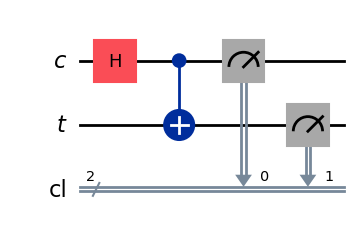

In [2]:
qc = QuantumCircuit(QuantumRegister(1, "c"), QuantumRegister(1, "t"), ClassicalRegister(2, "cl"))
qc.h(0)
qc.cx(0, 1)
qc.measure(range(2), range(2))
qc.draw(output="mpl")

After running this circuit, we obtain the Bell state

$$
\frac{1}{\sqrt{2}}(\ket{00} + \ket{11}) \,.
$$

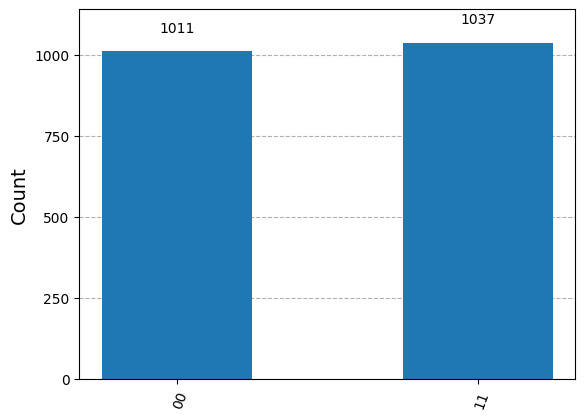

In [3]:
counts = simulate(qc)
plot_histogram(counts)

### Equivalent Gate-Based Program

On a neutral atom computer, it will be easier to apply $RY(\theta)$ (i.e., rotation around $y$-axis on the Bloch sphere) and the $CZ$ gate (i.e., controlled $RZ$ gate). We can rewrite the program above equivalently using only $RY(\theta)$ and $CZ$ gates.

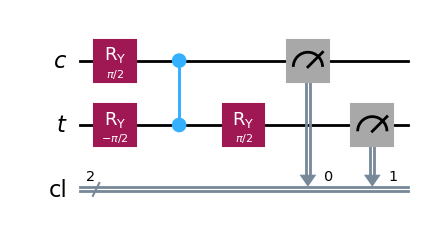

In [4]:
qc_equiv = QuantumCircuit(QuantumRegister(1, "c"), QuantumRegister(1, "t"), ClassicalRegister(2, "cl"))
qc_equiv.ry(np.pi/2, 0)
qc_equiv.ry(-np.pi/2, 1)
qc_equiv.cz(0, 1)
qc_equiv.ry(np.pi/2, 1)
qc_equiv.measure(range(2), range(2))
qc_equiv.draw(output="mpl", style="iqp")

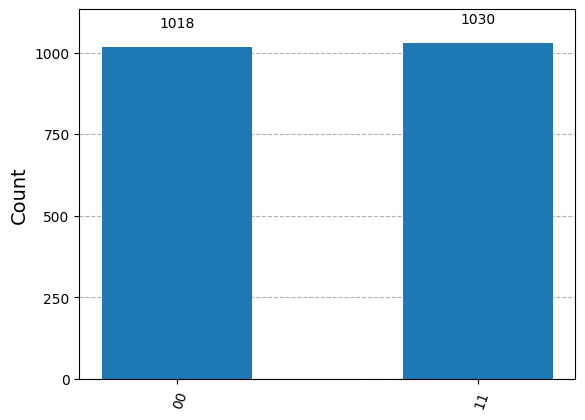

In [5]:
counts = simulate(qc_equiv)
plot_histogram(counts)

### Pulse Sequence Program

We begin by defining the qubits in a register. We'll use two qubits labeled `c` and `t` respectively.

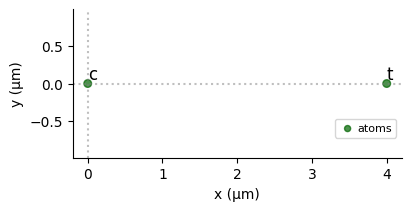

In [6]:
qubits = {
    'c': (0, 0),
    't': (4, 0)
}
reg = Register(qubits)
reg.draw()

#### Pulse

A **pulse** is a signal $p: [T_1, T_2] \rightarrow \mathbb{R}$. One popular pulse is known as the **Blackman waveform**.

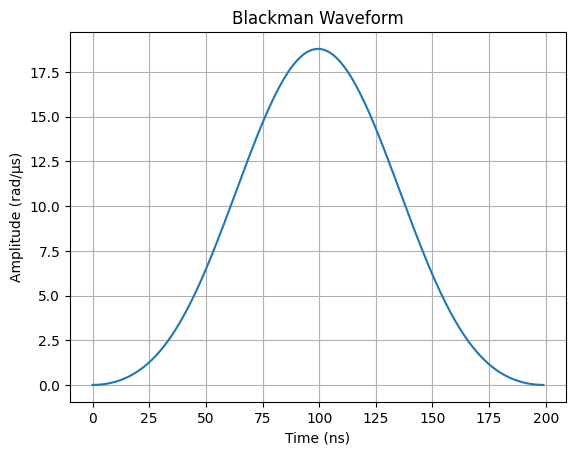

In [7]:
half_pi_wf = BlackmanWaveform(200, np.pi/2)
plt.plot(half_pi_wf.samples)
plt.title("Blackman Waveform")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (rad/µs)")
plt.grid(True)

#### Pulse Sequence

A **pulse sequence** is a list of pulses. We'll define two channels to accumulate pulse sequences using `pulser`.
1. The `single` channel will be used to accumulate pulses applied to single qubits.
2. The `rydberg` channel will be used to accumulate pulses applied to multiple qubits.

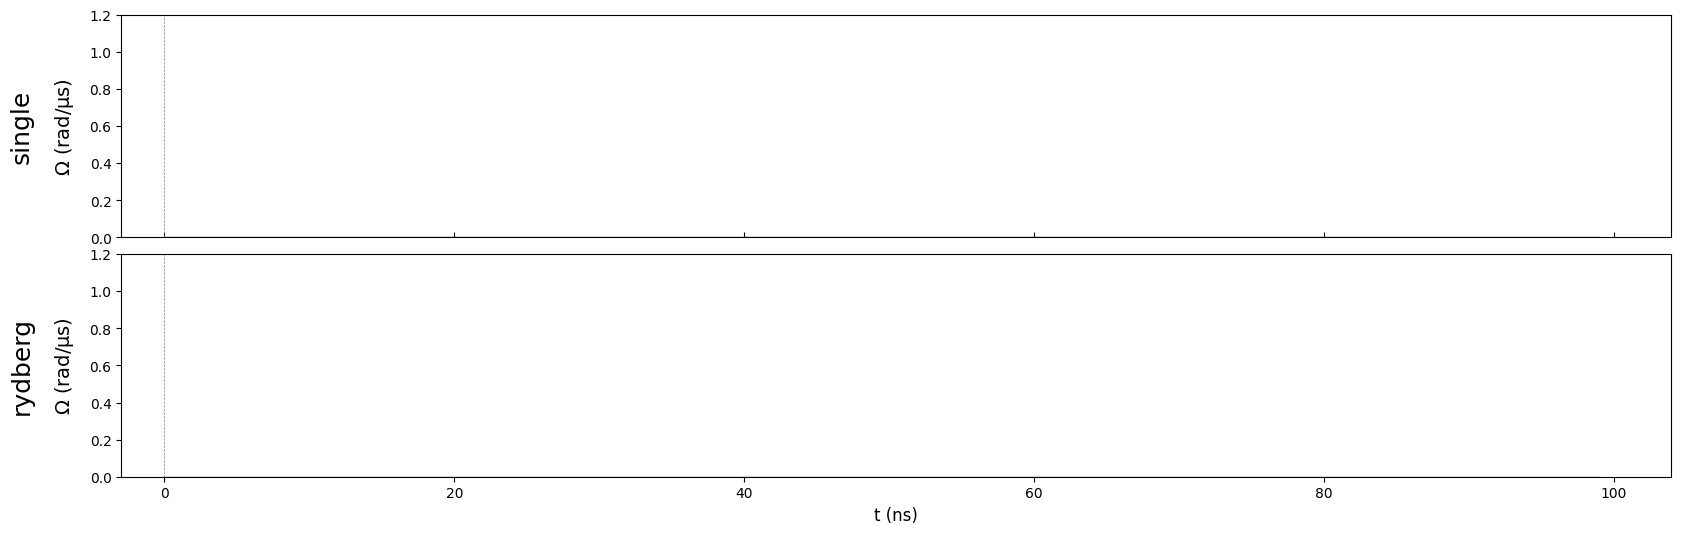

In [8]:
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel(
    'single',        # Name of channel
    'raman_local'    # Single qubit channel only requires raman component
)
seq.declare_channel(
    'rydberg',       # Name of channel
    'rydberg_local'  # Multi-qubit channel requires Rydberg Blockade
)
seq.draw(draw_phase_curve=True)

##### $RY(\pi/2)$

We can use our first pulse sequence to simulate a $RY(\pi/2)$ gate.

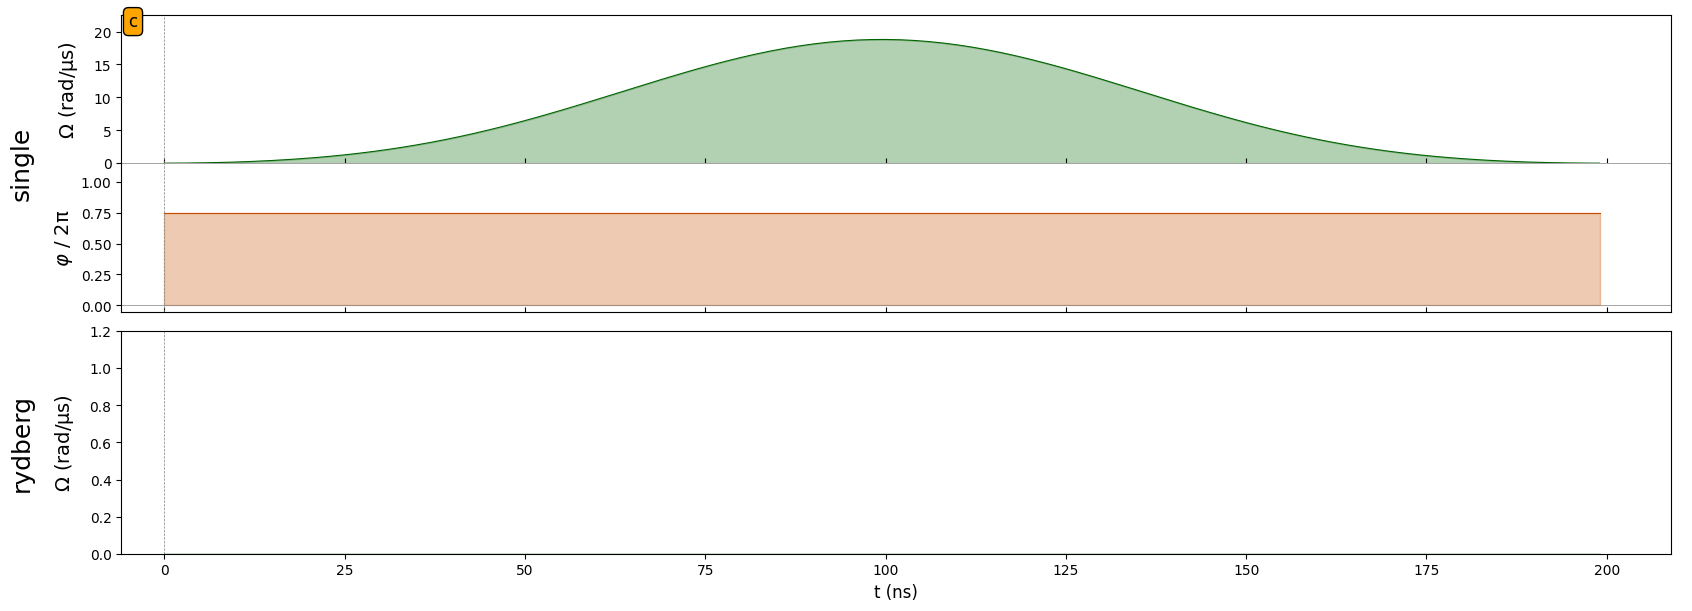

In [9]:
ry_pulse = Pulse.ConstantDetuning(
    amplitude=half_pi_wf,
    detuning=0,
    phase=-np.pi/2,
)
seq.target('c', 'single')
seq.add(ry_pulse, 'single')
seq.draw(draw_phase_curve=True)

##### $RY(-\pi/2)$

We can also apply $RY(-\pi/2)$ by changing the phase. Note that the qubit we are applying the qubit to is notated in the top-left.

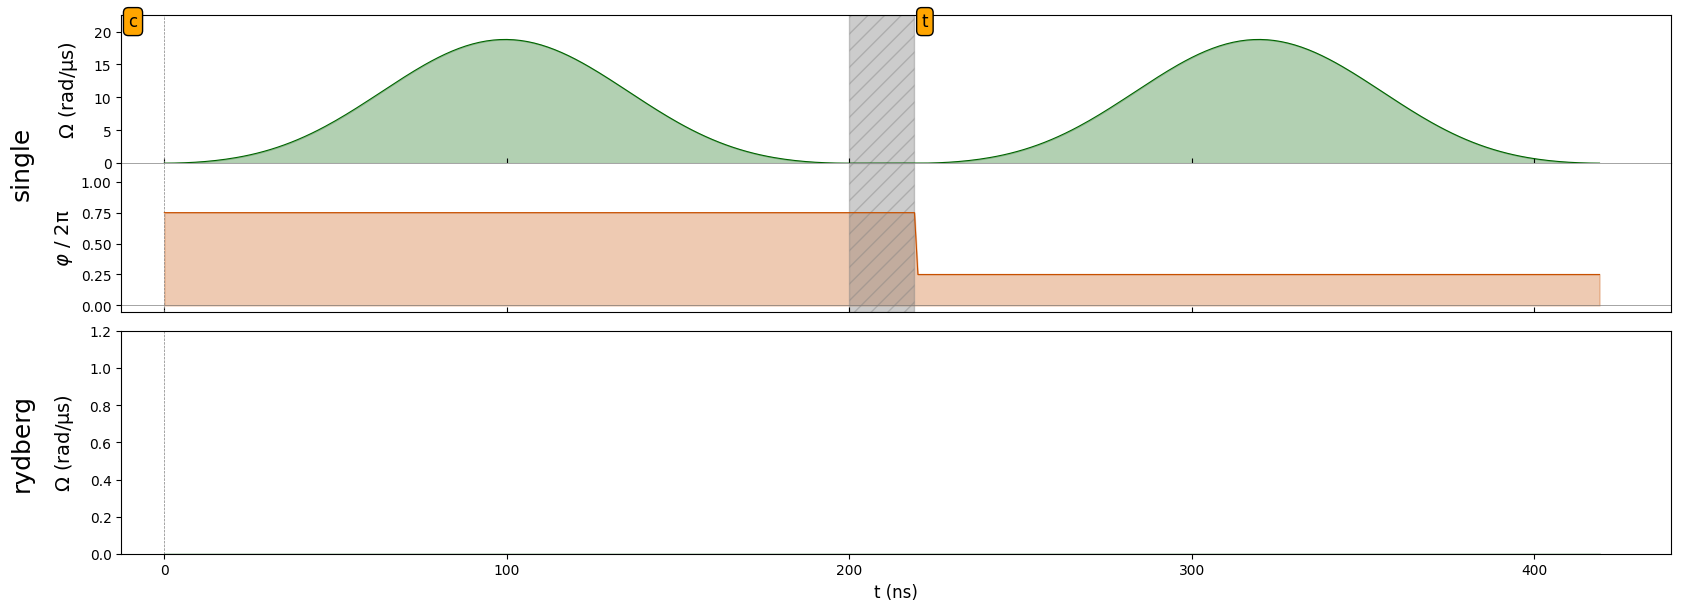

In [10]:
ry_dag_pulse = Pulse.ConstantDetuning(
    amplitude=half_pi_wf,
    detuning=0,
    phase=np.pi/2,
)
seq.target('t', 'single')
seq.add(ry_dag_pulse, 'single')
seq.draw(draw_phase_curve=True)

##### CZ Gate

We will now apply the sequence of pulses corresponding to a CZ gate. To accomplish this, we will need to use the Rydberg Blockade so that nearby atoms can interact and devise more pulses.

In [11]:
max_val = DigitalAnalogDevice.rabi_from_blockade(8)
max_val

20.67626392364502

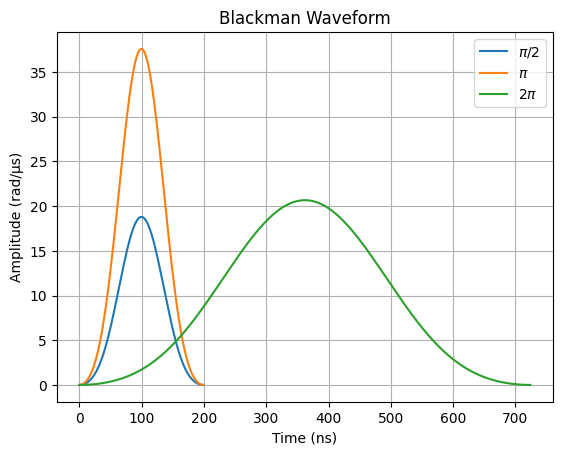

In [12]:
pi_wf = BlackmanWaveform(200, np.pi)
two_pi_wf = BlackmanWaveform.from_max_val(
    max_val=max_val,
    area=2*np.pi,
)
plt.plot(half_pi_wf.samples, label=r"$\pi/2$")
plt.plot(pi_wf.samples, label=r"$\pi$")
plt.plot(two_pi_wf.samples, label=r"$2\pi$")
plt.title("Blackman Waveform")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (rad/µs)")
plt.grid(True)
plt.legend();

/Users/dehuang/anaconda3/envs/learn/lib/python3.12/site-packages/pulser/sequence/sequence.py:1302: UserWarning: A duration of 725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 728 ns.
  self._add(pulse, channel, protocol)


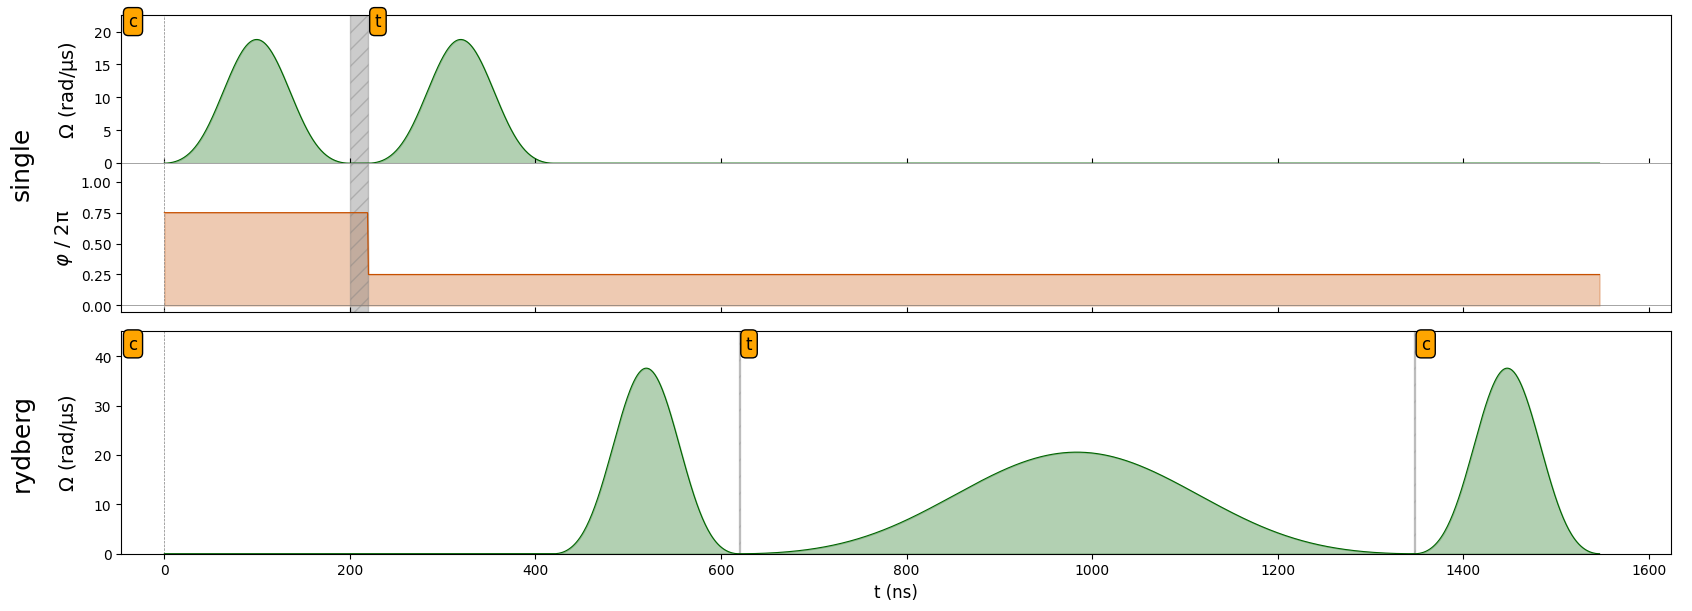

In [13]:
seq.target('c', 'rydberg')
seq.align('single', 'rydberg')
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)
seq.add(pi_pulse, 'rydberg')
two_pi_pulse = Pulse.ConstantDetuning(
    amplitude=two_pi_wf,
    detuning=0,
    phase=0,
)
seq.target('t', 'rydberg')
seq.add(two_pi_pulse, 'rydberg')
seq.target('c', 'rydberg')
seq.add(pi_pulse, 'rydberg')
seq.draw(draw_phase_curve=True)

##### $RY(\pi/2)$

Finally, we apply the last $RY(\pi/2)$ gate.

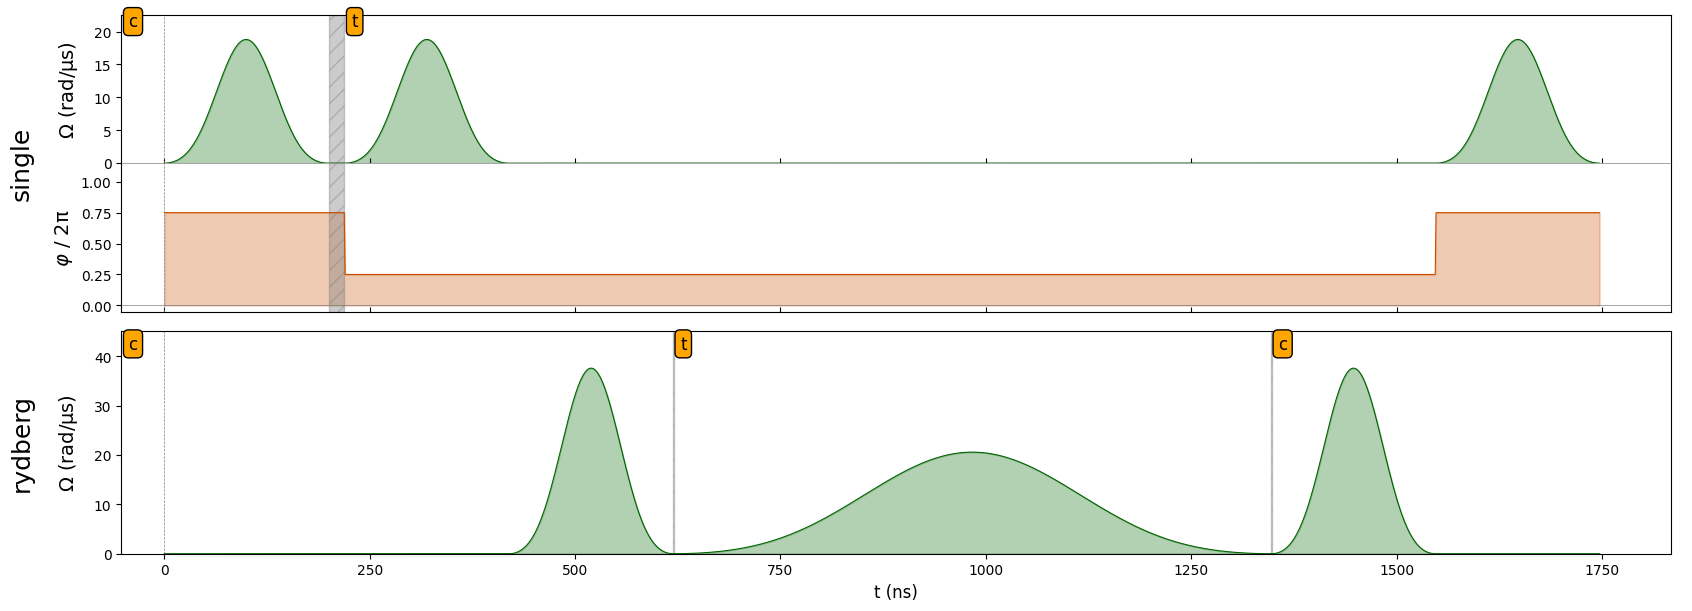

In [14]:
seq.align('single', 'rydberg')
seq.add(ry_pulse, 'single')
seq.draw(draw_phase_curve=True)

##### Measurement

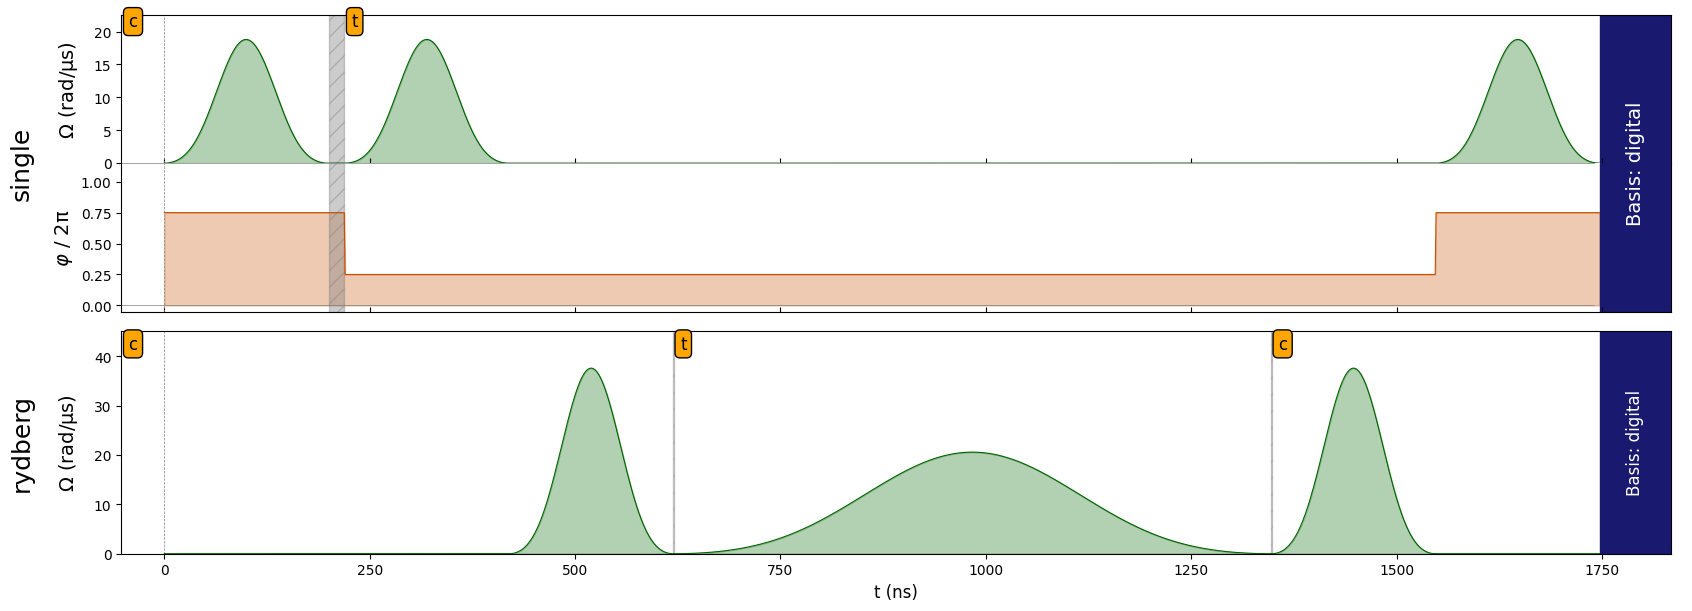

In [15]:
seq.measure(basis='digital')
seq.draw(draw_phase_curve=True)

/Users/dehuang/anaconda3/envs/learn/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/Users/dehuang/anaconda3/envs/learn/lib/python3.12/site-packages/qutip/solver/solver_base.py:459: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


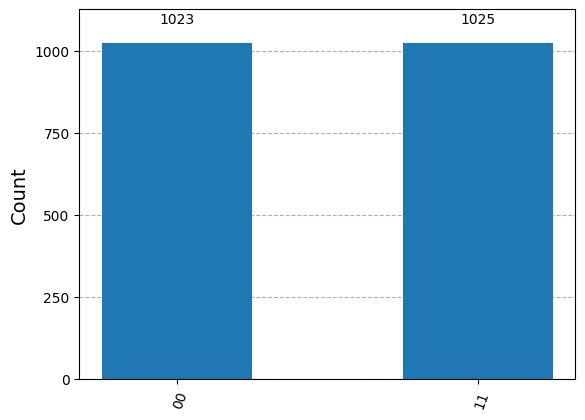

In [16]:
sim = QutipEmulator.from_sequence(seq)
res = sim.run()
counts = res.sample_final_state(N_samples=2048)
plot_histogram(counts)

## Summary

1. We saw how to program a neutral atom quantum computer with pulse sequences.
2. A pulse sequence gives fine-grained and analog control over the implementation of a digital gates.
3. We saw how to use the Rydberg blockade to implement a pulse sequence to implement the $CZ$ gate.

## References

[1] [Pulser: An open-source package for the design of pulse sequences in programmable neutral-atom arraysm](https://quantum-journal.org/papers/q-2022-01-24-629/pdf/)